<a href="https://colab.research.google.com/github/marbucek/fashion-MNIST/blob/master/fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 1.x #I chose to work with tensorflow 1.15 since training on GPUs was not fully functioning in GoogleColab with the 2.0 version

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow  as tf
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input, Lambda, Dropout, DepthwiseConv2D, BatchNormalization, ReLU
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, KFold

from matplotlib import pyplot as plt

from scipy.ndimage import rotate

mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train[:,:,:,np.newaxis], x_test[:,:,:,np.newaxis]
x_train, x_test = x_train / 255.0, x_test / 255.0

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x #I chose to work with tensorflow 1.15 since training on GPUs was not fully functioning in GoogleColab with the 2.0 version`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
4423680/4422102 [==============================] - 0s 0us/step


#Simple CNN architecture

In [49]:
model = tf.keras.Sequential([
    Conv2D(16, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)),
    Conv2D(16, kernel_size=3, activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2, padding = 'same'),
    Conv2D(32, kernel_size=3, activation='relu', padding = 'same'),
    Conv2D(32, kernel_size=3, activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2,2), strides=2, padding = 'same'),
    Conv2D(32, kernel_size=3, activation='relu', padding = 'same'),
    Conv2D(32, kernel_size=3, activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    tf.keras.layers.Dropout(rate = 0.5),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

opt = tf.keras.optimizers.Adam(0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.save_weights('init_weights.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 32)          9

In [83]:
#calculate the number of steps
def get_complexity(model):
  steps_total = 0
  for layer in model.layers:
    if isinstance(layer, Conv2D):
      steps = np.prod(layer.kernel_size)*np.prod(layer.input_shape[1:])*layer.output_shape[-1]/np.prod(layer.strides)
      print(f'{layer}, steps = {steps}')

    elif isinstance(layer, DepthwiseConv2D):
      steps = np.prod(layer.kernel_size)*np.prod(layer.input_shape[1:])/np.prod(layer.strides)
      print(f'{layer}, steps = {steps}')

    elif isinstance(layer, MaxPool2D):
      steps = np.prod(layer.pool_size)*np.prod(layer.input_shape[1:])/np.prod(layer.strides)
      print(f'{layer}, steps = {steps}')

    elif isinstance(layer, Dense):
      steps = layer.input_shape[-1]*layer.output_shape[-1]
      print(f'{layer}, steps = {steps}')

    else:
      steps = 0
    steps_total += steps

  print(f'Total {steps_total/1e6:.1f}M steps.')

get_complexity(model)

<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f86bde63240>, steps = 112896.0
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f86bde636a0>, steps = 1806336.0
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f86bde63ac8>, steps = 12544.0
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f86bde63cf8>, steps = 903168.0
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f86bde5c160>, steps = 1806336.0
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f86bde5c588>, steps = 6272.0
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f86bde5c7b8>, steps = 451584.0
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f86bde5cbe0>, steps = 451584.0
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f86bde56048>, steps = 1568.0
<tensorflow.python.keras.layers.core.Dense object at 0x7f86bde564e0>, steps = 36864
<tensorflow.python.keras.layers.core.Dense obj

Training procedure using early stopping and data augmentation

In [0]:
def train(model, epochs=30, lr=0.001, verbose = 0, scheduler = None, patience=10, augment=None, init_weights='init_weights.h5'):

    opt = tf.keras.optimizers.Adam(lr)
    model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    x_tr, x_vld, y_tr, y_vld = train_test_split(x_train, y_train, test_size = 0.1)

    if augment == 'flip':
        #x_tr, y_tr = tf.concat([x_tr, tf.image.flip_left_right(x_tr)], axis=0), np.concatenate(2*[y_tr])
        
        x_tr = np.concatenate([x_tr, np.flip(x_tr, axis=1)],
                                    axis=0)
        y_tr = np.concatenate(2*[y_tr])

    if augment == 'flip_rotate':
        x_rot = np.stack([rotate(x, np.random.normal(0, 22.5/2), reshape=False) for x in x_tr], axis = 0)
        x_tr = np.concatenate([x_tr, x_rot, 
                               np.flip(x_tr, axis=1),
                               np.flip(x_rot, axis = 1)],
                              axis=0)
        y_tr = np.concatenate(4*[y_tr])
        #x_rot = tfa.image.rotate(x_tr, angles = tf.random.normal(shape = [x_tr.shape[0]], mean = 0.0, stddev = np.pi/16))
        #x_tr, y_tr = tf.concat([x_tr, x_rot, tf.image.flip_left_right(x_tr), tf.image.flip_left_right(x_rot)], axis=0), np.concatenate(4*[y_tr])

    es = EarlyStopping(monitor='val_loss', patience=patience, verbose=0, restore_best_weights=True)
    model.load_weights(init_weights)
    print('Weights loaded')
    history = model.fit(x_tr, y_tr, batch_size=64, epochs = epochs, verbose = verbose,
                      validation_data = (x_vld, y_vld),
                      callbacks = [es] if scheduler == None else [es, scheduler])

    _, vld_acc = model.evaluate(x_vld,  y_vld, verbose=0)
    print('\nStop epoch: {}, validation accuracy: {}'.format(es.stopped_epoch, vld_acc))
    _, test_acc = model.evaluate(x_test,  y_test, verbose=0)
    print('\nTest accuracy: {}'.format(test_acc))

    return history


Stop epoch: 40, validation accuracy: 0.9281666874885559

Test accuracy: 0.9251999855041504


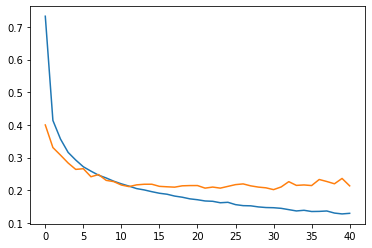

In [0]:
#no data augmentation
history = train(model, 50, 0.001, verbose=0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


Stop epoch: 33, validation accuracy: 0.9254999756813049

Test accuracy: 0.9186999797821045


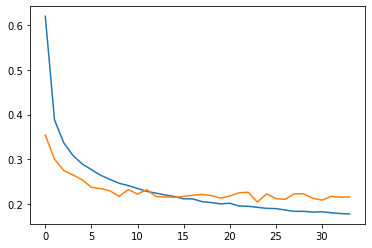

In [0]:
#augmenting the data by horizontal flipping
history = train(model, 50, 0.001, verbose=0, augment='flip')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


Stop epoch: 41, validation accuracy: 0.9233333468437195

Test accuracy: 0.9115999937057495


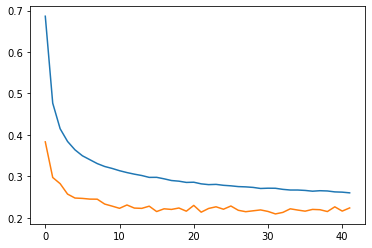

In [0]:
#augmenting the data by horizontal flipping and rotations
history = train(model, 50, lr = 0.001, verbose=0, augment='flip_rotate')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

#Transfer learning on MobileNet

In [84]:
input_image = Input(shape = (28,28,1))
resized = Lambda(lambda x: tf.image.resize(x, size = tf.constant([56,56])))(input_image)
stacked = Lambda(lambda x: tf.concat(3*[x], axis = -1))(resized) #MobileNet accepts only input with three channels
base_model = tf.keras.applications.MobileNet(input_tensor = stacked, include_top=False, pooling='avg', weights='imagenet')
output = Dropout(0.5)(base_model.output)
predict = Dense(10, activation='softmax')(output)
mob_net = Model(inputs=input_image, outputs=predict)

mob_net.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mob_net.summary()
model.save_weights('init_weights_mob_net.h5')
get_complexity(mob_net) #estimate the number of operations / forward step

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 56, 56, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 57, 57, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 28, 28, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 28, 28, 32)        0   

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 28s 518us/sample - loss: 0.4857 - acc: 0.8512 - val_loss: 0.2883 - val_acc: 0.9043
Epoch 2/50
54000/54000 [==============================] - 20s 374us/sample - loss: 0.2654 - acc: 0.9099 - val_loss: 0.2391 - val_acc: 0.9155
Epoch 3/50
54000/54000 [==============================] - 20s 376us/sample - loss: 0.2070 - acc: 0.9294 - val_loss: 0.2067 - val_acc: 0.9303
Epoch 4/50
54000/54000 [==============================] - 20s 374us/sample - loss: 0.1800 - acc: 0.9383 - val_loss: 0.2132 - val_acc: 0.9325
Epoch 5/50
54000/54000 [==============================] - 20s 372us/sample - loss: 0.1498 - acc: 0.9491 - val_loss: 0.1811 - val_acc: 0.9405
Epoch 6/50
54000/54000 [==============================] - 20s 375us/sample - loss: 0.1258 - acc: 0.9569 - val_loss: 0.2034 - val_acc: 0.9322
Epoch 7/50
54000/54000 [==============================] - 20s 373us/sample - loss: 0.0966 - acc: 0.9671 -

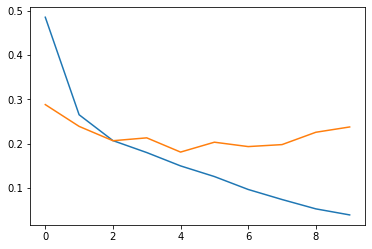

In [0]:
mob_net = Model(inputs=input_image, outputs=predict)
lr, lr_decay, epochs_decay = 0.001, 0.8, 1
scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr*lr_decay**(epoch//epochs_decay))
history = train(mob_net, 50, 0.001, verbose=1, patience=5, scheduler = scheduler, init_weights='init_weights_mob_net.h5')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Train on 108000 samples, validate on 6000 samples
Epoch 1/50
108000/108000 [==============================] - 39s 359us/sample - loss: 0.1724 - acc: 0.9409 - val_loss: 0.1610 - val_acc: 0.9450
Epoch 2/50
108000/108000 [==============================] - 36s 337us/sample - loss: 0.1372 - acc: 0.9524 - val_loss: 0.1504 - val_acc: 0.9447
Epoch 3/50
108000/108000 [==============================] - 36s 336us/sample - loss: 0.1034 - acc: 0.9644 - val_loss: 0.1264 - val_acc: 0.9513
Epoch 4/50
108000/108000 [==============================] - 37s 340us/sample - loss: 0.0770 - acc: 0.9731 - val_loss: 0.1529 - val_acc: 0.9485
Epoch 5/50
108000/108000 [==============================] - 36s 338us/sample - loss: 0.0560 - acc: 0.9804 - val_loss: 0.1364 - val_acc: 0.9533
Epoch 6/50
108000/108000 [==============================] - 36s 333us/sample - loss: 0.0395 - acc: 0.9865 - val_loss: 0.1421 - val_acc: 0.9555
Epoch 7/50
108000/108000 [==============================] - 36s 334us/sample - loss: 0.0259 

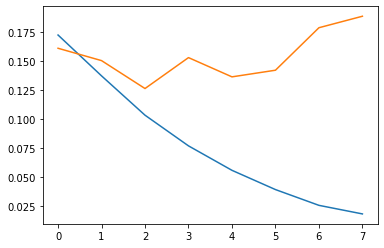

In [0]:
mob_net = Model(inputs=input_image, outputs=predict)
lr, lr_decay, epochs_decay = 0.0003, 0.8, 1
scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr*lr_decay**(epoch//epochs_decay))
history = train(mob_net, 50, 0.001, verbose=1, patience=5, augment='flip', scheduler = scheduler, init_weights='init_weights_mob_net.h5')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Train on 216000 samples, validate on 6000 samples
Epoch 1/50
216000/216000 [==============================] - 75s 347us/sample - loss: 0.4690 - acc: 0.8472 - val_loss: 0.2724 - val_acc: 0.9018
Epoch 2/50
216000/216000 [==============================] - 71s 328us/sample - loss: 0.2504 - acc: 0.9120 - val_loss: 0.2314 - val_acc: 0.9157
Epoch 3/50
216000/216000 [==============================] - 71s 327us/sample - loss: 0.1944 - acc: 0.9318 - val_loss: 0.1910 - val_acc: 0.9312
Epoch 4/50
216000/216000 [==============================] - 71s 328us/sample - loss: 0.1498 - acc: 0.9469 - val_loss: 0.1824 - val_acc: 0.9395
Epoch 5/50
216000/216000 [==============================] - 71s 327us/sample - loss: 0.1124 - acc: 0.9597 - val_loss: 0.1865 - val_acc: 0.9420
Epoch 6/50
216000/216000 [==============================] - 71s 327us/sample - loss: 0.0820 - acc: 0.9708 - val_loss: 0.1891 - val_acc: 0.9442
Epoch 7/50
216000/216000 [==============================] - 71s 327us/sample - loss: 0.0581 

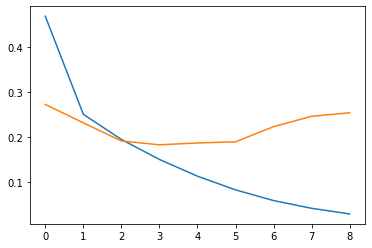

In [0]:
#mob_net = Model(inputs=input_image, outputs=predict)
lr, lr_decay, epochs_decay = 0.0003, 0.8, 1
scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr*lr_decay**(epoch//epochs_decay))
history = train(mob_net, 50, 0.001, verbose=1, patience=5, augment='flip_rotate', scheduler = scheduler, init_weights='init_weights_mob_net.h5')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Simplified MobileNet

MobileNet architecture using only the first 5 depthwise convolution layers

In [85]:
input_image = Input(shape = (28,28,1))
resized = Lambda(lambda x: tf.image.resize(x, size = tf.constant([56,56])))(input_image)
stacked = Lambda(lambda x: tf.concat(3*[x], axis = -1))(resized) #MobileNet accepts only input with three channels
base_model = tf.keras.applications.MobileNet(input_tensor = stacked, include_top=False, pooling='avg', weights='imagenet')
base_model_output = base_model.layers[37].output
flattened = tf.keras.layers.GlobalAvgPool2D(name = 'gl_avg_pooling')(base_model_output)
output = Dropout(0.5)(flattened)
predict = Dense(10, activation='softmax')(output)

mob_net2 = Model(inputs=input_image, outputs=predict)
mob_net2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mob_net2.summary()
mob_net2.save_weights('init_weights_mob_net_reduced.h5')

get_complexity(mob_net2)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
lambda_8 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
lambda_9 (Lambda)            (None, 56, 56, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 57, 57, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 28, 28, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 28, 28, 32)        0   

Weights loaded
Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 - 16s - loss: 0.5368 - acc: 0.8229 - val_loss: 0.3578 - val_acc: 0.8805
Epoch 2/50
54000/54000 - 11s - loss: 0.2602 - acc: 0.9094 - val_loss: 0.2990 - val_acc: 0.8952
Epoch 3/50
54000/54000 - 11s - loss: 0.2107 - acc: 0.9251 - val_loss: 0.2792 - val_acc: 0.9017
Epoch 4/50
54000/54000 - 11s - loss: 0.1781 - acc: 0.9368 - val_loss: 0.2689 - val_acc: 0.9122
Epoch 5/50
54000/54000 - 11s - loss: 0.1564 - acc: 0.9456 - val_loss: 0.2519 - val_acc: 0.9158
Epoch 6/50
54000/54000 - 11s - loss: 0.1337 - acc: 0.9535 - val_loss: 0.2139 - val_acc: 0.9308
Epoch 7/50
54000/54000 - 11s - loss: 0.1174 - acc: 0.9587 - val_loss: 0.2011 - val_acc: 0.9332
Epoch 8/50
54000/54000 - 11s - loss: 0.1014 - acc: 0.9657 - val_loss: 0.2023 - val_acc: 0.9332
Epoch 9/50
54000/54000 - 11s - loss: 0.0884 - acc: 0.9701 - val_loss: 0.2067 - val_acc: 0.9328
Epoch 10/50
54000/54000 - 11s - loss: 0.0799 - acc: 0.9731 - val_loss: 0.2129 - v

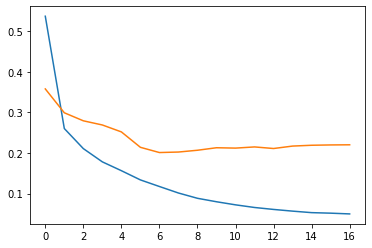

In [0]:
lr, lr_decay, epochs_decay = 0.001, 0.8, 1
scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr*lr_decay**(epoch//epochs_decay))
history = train(mob_net2, 50, 0.001, verbose=2, patience=10, scheduler = scheduler, init_weights='init_weights_mob_net_reduced.h5')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Weights loaded
Train on 108000 samples, validate on 6000 samples
Epoch 1/50
108000/108000 - 26s - loss: 0.6663 - acc: 0.7798 - val_loss: 0.3151 - val_acc: 0.8895
Epoch 2/50
108000/108000 - 22s - loss: 0.3204 - acc: 0.8888 - val_loss: 0.2566 - val_acc: 0.9127
Epoch 3/50
108000/108000 - 22s - loss: 0.2621 - acc: 0.9086 - val_loss: 0.2428 - val_acc: 0.9125
Epoch 4/50
108000/108000 - 22s - loss: 0.2297 - acc: 0.9204 - val_loss: 0.2230 - val_acc: 0.9232
Epoch 5/50
108000/108000 - 22s - loss: 0.2108 - acc: 0.9266 - val_loss: 0.2247 - val_acc: 0.9207
Epoch 6/50
108000/108000 - 22s - loss: 0.1965 - acc: 0.9312 - val_loss: 0.2125 - val_acc: 0.9260
Epoch 7/50
108000/108000 - 22s - loss: 0.1840 - acc: 0.9359 - val_loss: 0.2046 - val_acc: 0.9277
Epoch 8/50
108000/108000 - 22s - loss: 0.1761 - acc: 0.9389 - val_loss: 0.2007 - val_acc: 0.9308
Epoch 9/50
108000/108000 - 22s - loss: 0.1697 - acc: 0.9408 - val_loss: 0.2017 - val_acc: 0.9312
Epoch 10/50
108000/108000 - 22s - loss: 0.1626 - acc: 0.9429 -

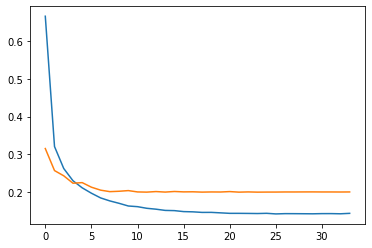

In [0]:
lr, lr_decay, epochs_decay = 0.0003, 0.8, 1
scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr*lr_decay**(epoch//epochs_decay))
history = train(mob_net2, 50, 0.001, verbose=2, patience=10, augment='flip', scheduler = scheduler, init_weights='init_weights_mob_net_reduced.h5')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Weights loaded
Train on 216000 samples, validate on 6000 samples
Epoch 1/50
216000/216000 - 49s - loss: 0.5611 - acc: 0.8114 - val_loss: 0.3037 - val_acc: 0.8943
Epoch 2/50
216000/216000 - 45s - loss: 0.2943 - acc: 0.8968 - val_loss: 0.2400 - val_acc: 0.9170
Epoch 3/50
216000/216000 - 44s - loss: 0.2497 - acc: 0.9121 - val_loss: 0.2223 - val_acc: 0.9232
Epoch 4/50
216000/216000 - 44s - loss: 0.2256 - acc: 0.9202 - val_loss: 0.2501 - val_acc: 0.9133
Epoch 5/50
216000/216000 - 44s - loss: 0.2071 - acc: 0.9267 - val_loss: 0.2163 - val_acc: 0.9270
Epoch 6/50
216000/216000 - 44s - loss: 0.1934 - acc: 0.9315 - val_loss: 0.2078 - val_acc: 0.9308
Epoch 7/50
216000/216000 - 44s - loss: 0.1838 - acc: 0.9346 - val_loss: 0.2063 - val_acc: 0.9300
Epoch 8/50
216000/216000 - 44s - loss: 0.1765 - acc: 0.9372 - val_loss: 0.2030 - val_acc: 0.9307
Epoch 9/50
216000/216000 - 44s - loss: 0.1691 - acc: 0.9403 - val_loss: 0.2039 - val_acc: 0.9292
Epoch 10/50
216000/216000 - 44s - loss: 0.1637 - acc: 0.9420 -

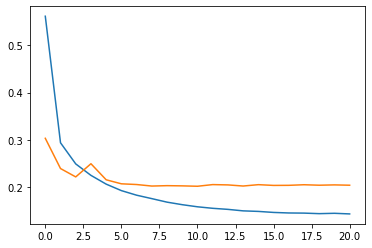

In [0]:
lr, lr_decay, epochs_decay = 0.0003, 0.8, 1
scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr*lr_decay**(epoch//epochs_decay))
history = train(mob_net2, 50, 0.001, verbose=2, patience=10, augment='flip_rotate', scheduler = scheduler, init_weights='init_weights_mob_net_reduced.h5')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])